# Santa Workshop Tour competition

This notebook builds tailormade models to organize a tour schedule, based on data provided on the [Santa's Workshop Tour 2019 competition](https://www.kaggle.com/c/santa-workshop-tour-2019/).

In [199]:
# Load dependencies.
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

import locale
locale.setlocale(locale.LC_ALL, 'en_US')

'en_US'

## 1. Load and parse data

In [200]:
# Load train and test data.
data = pd.read_csv('./data/family_data.csv', sep=',')
sample_submission = pd.read_csv('./data/sample_submission.csv', sep=',')

# Take a quick look into the data.
data.head(8)

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,52,38,12,82,33,75,64,76,10,28,4
1,1,26,4,82,5,11,47,38,6,66,61,4
2,2,100,54,25,12,27,82,10,89,80,33,3
3,3,2,95,1,96,32,6,40,31,9,59,2
4,4,53,1,47,93,26,3,46,16,42,39,4
5,5,32,59,12,3,60,26,35,50,5,2,4
6,6,88,4,1,3,91,32,39,57,28,99,2
7,7,25,11,52,48,10,17,88,50,95,66,5


In [201]:
# Define constants.
COLUMNS = [f'choice_{i}' for i in range(10)]

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

DAYS_LIST = list(range(N_DAYS, 0, -1)) # From 100 to 1

GIFT_CARD = [0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500]
BUFFET = [0, 0, 9, 9, 9, 18, 18, 36, 36, 36, 36]
HELICOPTER = [0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 398]

# Define auxiliary dictionaries from data.
family_size_dict = data[['n_people']].to_dict()['n_people']
choice_dict = data[COLUMNS].to_dict()

# Define occupancy and cost functions
def calc_daily_occupancy(prediction):
    daily_occupancy = {k:0 for k in DAYS_LIST}
    
    for family_index, assigned_day in enumerate(prediction):
        family_people = family_size_dict[family_index]
        daily_occupancy[assigned_day] += family_people
        
    return daily_occupancy
    
# Define cost formulas.
def calc_preference_cost(choice, family_members):
    cost = 0
    cost += GIFT_CARD[choice]
    cost += BUFFET[choice] * family_members
    cost += HELICOPTER[choice] * family_members
    return cost

def calc_accounting_cost(daily_occupancy):
    # The first day (day 100) is treated special.
    accounting_cost = (daily_occupancy[DAYS_LIST[0]]-125.0) / 400.0 * daily_occupancy[DAYS_LIST[0]]**(0.5)
    
    # Use the max function because the soft constraints might allow occupancy to dip below 125.
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count.
    yesterday_count = daily_occupancy[DAYS_LIST[0]]
    for day in DAYS_LIST[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    return accounting_cost
    
def calc_score(prediction):
    penalty = 0;
                 
    # Define an array to count the number of people scheduled each day.
    daily_occupancy = {k:0 for k in DAYS_LIST}
    
    # Loop over each family.
    for family_index, assigned_day in enumerate(prediction):
        # Add the family member count to the daily occupancy.
        family_people = family_size_dict[family_index]
        daily_occupancy[assigned_day] += family_people

        # Check which choice was selected.
        choice = 10
        for index, column in enumerate(COLUMNS):
            if assigned_day == choice_dict[column][family_index]:
                 choice = index
                 
        # Calculate the penalty for not getting top preference
        penalty += calc_preference_cost(choice, family_people)

    # For each date, check total occupancy (using soft constraints instead of hard ones).
    for _, occuppancy in daily_occupancy.items():
        if (occuppancy > MAX_OCCUPANCY) or (occuppancy < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost.
    penalty += calc_accounting_cost(daily_occupancy)

    return penalty

## 2. Explore data

In [202]:
# General stats.
print("Total number of families:", len(data))
print("Total number of visitors:", data['n_people'].sum())
print("Average people per family:", data['n_people'].sum()/len(data))
print("Average families per day:", len(data)/100)
print("Average people per day:", data['n_people'].sum()/N_DAYS)

Total number of families: 5000
Total number of visitors: 21003
Average people per family: 4.2006
Average families per day: 50.0
Average people per day: 210.03


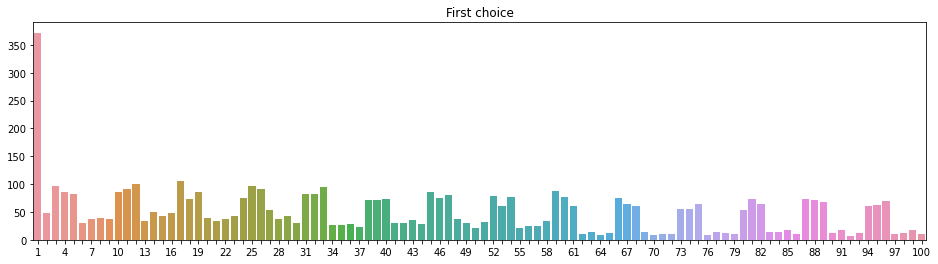

In [203]:
# Check occurrences for the first choice.
occurrences_0 = data['choice_0'].value_counts().sort_index()

# Draw bar chart.
plt.figure(figsize=(16,4))
plt.title("First choice")
sns.barplot(x=occurrences_0.index, y=occurrences_0.values)

# Don't show all labels on X-axis.
ax = plt.gca()
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 3 != 0:
        label.set_visible(False)

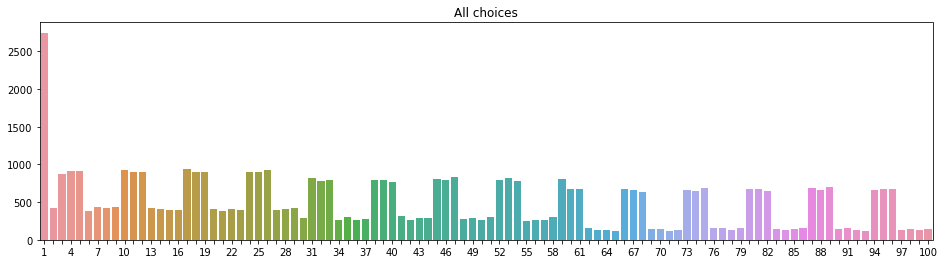

In [204]:
# Check occurrences for all choices.
occurrences = None
for column in COLUMNS:
    counts = data[column].value_counts()
    if occurrences is None:
        occurrences = counts
    else:
        occurrences += counts
occurrences = occurrences.sort_index()

# Draw bar chart.
plt.figure(figsize=(16,4))
plt.title("All choices")
sns.barplot(x=occurrences.index, y=occurrences.values)

# Don't show all labels on X-axis.
ax = plt.gca()
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 3 != 0:
        label.set_visible(False)

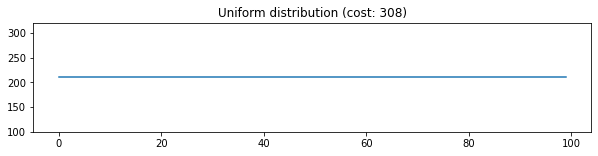

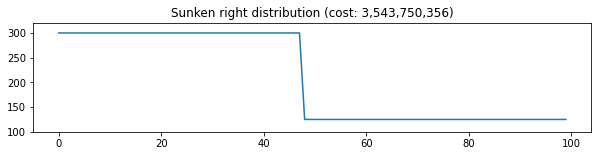

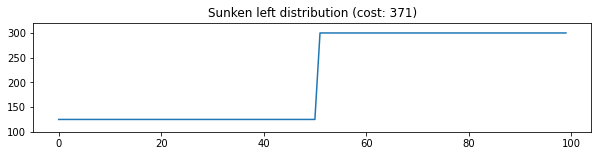

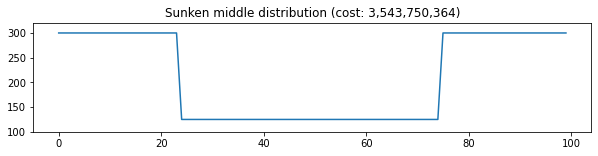

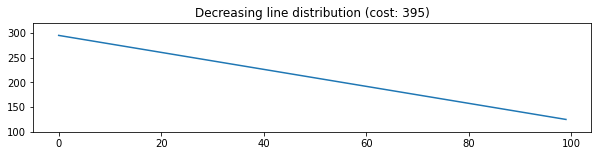

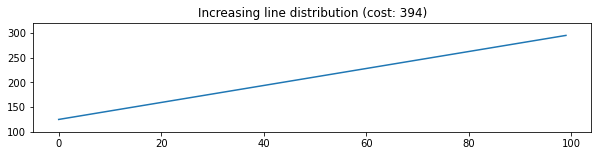

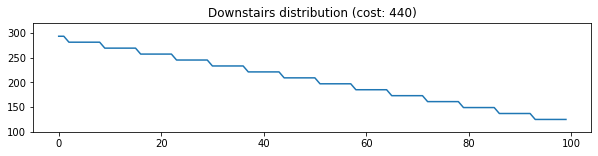

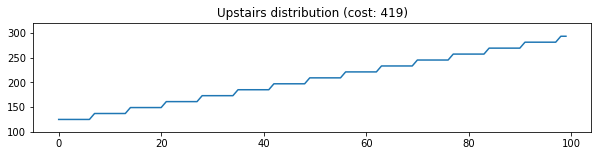

In [205]:
# Check accounting cost for different distributions.
total_visitors = data['n_people'].sum()

def distributon_lineplot(name, distribution):
    accounting_cost = calc_accounting_cost(distribution)
    sorted_values = [distribution[key] for key in sorted(distribution.keys())]
    
    plt.figure(figsize=(10,2))
    plt.ylim(100, 320)
    plt.title(name + " (cost: " + locale.format_string("%.0f", accounting_cost, grouping=True) + ")")   
    sns.lineplot(data=np.fromiter(sorted_values, dtype=float))
    
uniform_dist = {k:(total_visitors/N_DAYS) for k in DAYS_LIST}
distributon_lineplot("Uniform distribution", uniform_dist)

skew_limit = (total_visitors - (N_DAYS * MIN_OCCUPANCY)) / (MAX_OCCUPANCY - MIN_OCCUPANCY)
sunken_right_dist = {k:(MIN_OCCUPANCY if k > skew_limit else MAX_OCCUPANCY) for k in DAYS_LIST}
sunken_left_dist = {k:(MAX_OCCUPANCY if (N_DAYS - k) < skew_limit else MIN_OCCUPANCY) for k in DAYS_LIST}
corner_generator = lambda k:(MAX_OCCUPANCY if ((k < skew_limit/2) or ((N_DAYS - k) < skew_limit/2)) else MIN_OCCUPANCY)
sunken_middle_dist = {k:corner_generator(k) for k in DAYS_LIST}
distributon_lineplot("Sunken right distribution", sunken_right_dist)
distributon_lineplot("Sunken left distribution", sunken_left_dist)
distributon_lineplot("Sunken middle distribution", sunken_middle_dist)

step_size = (total_visitors - (MIN_OCCUPANCY*N_DAYS)) / (N_DAYS*(N_DAYS - 1)*0.5) 
decreasing_dist = {k:(MIN_OCCUPANCY + (N_DAYS-k)*step_size ) for k in DAYS_LIST}
increasing_dist = {k:(MIN_OCCUPANCY + (k-1)*step_size ) for k in DAYS_LIST}
distributon_lineplot("Decreasing line distribution", decreasing_dist)
distributon_lineplot("Increasing line distribution", increasing_dist)

downstairs_dist = {k:(MIN_OCCUPANCY + ((N_DAYS-k)//7)*7*step_size ) for k in DAYS_LIST}
upstairs_dist = {k:(MIN_OCCUPANCY + ((k-1)//7)*7*step_size ) for k in DAYS_LIST}
distributon_lineplot("Downstairs distribution", downstairs_dist)
distributon_lineplot("Upstairs distribution", upstairs_dist)

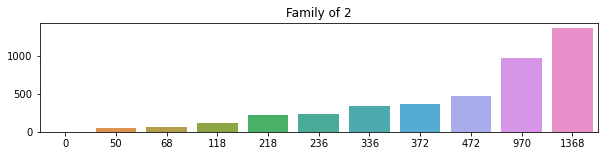

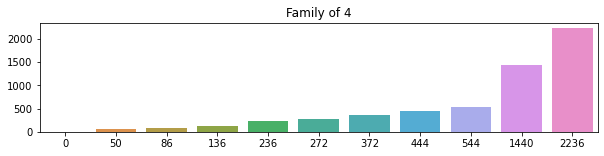

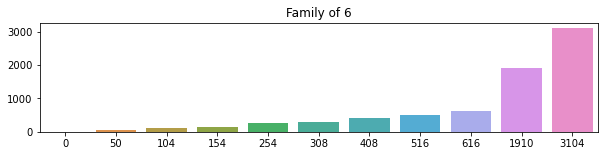

In [206]:
# Check preferences cost for families or different size.
costs = [calc_preference_cost(k, 2) for k in range(11)]
plt.figure(figsize=(10,2))
plt.title("Family of 2")
sns.barplot(x=costs, y=costs)

costs = [calc_preference_cost(k, 4) for k in range(11)]
plt.figure(figsize=(10,2))
plt.title("Family of 4")
sns.barplot(x=costs, y=costs)

costs = [calc_preference_cost(k, 6) for k in range(11)]
plt.figure(figsize=(10,2))
plt.title("Family of 6")
sns.barplot(x=costs, y=costs)

## 3. Build models

### 3.1 Submission sample

In [207]:
# Check score of sample submission.
sample_pred = sample_submission['assigned_day'].tolist()
sample_score = calc_score(sample_pred)
print("Submission sample cost:", locale.format_string("%d", sample_score, grouping=True))

Submission sample cost: 10,641,498


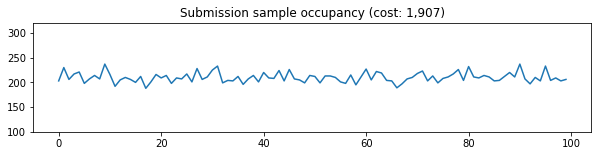

In [208]:
sample_occupancy = calc_daily_occupancy(sample_pred)
distributon_lineplot("Submission sample occupancy", sample_occupancy)

### 3.2 Improve submission sample

In [209]:
def improve_prediction(prediction):
    # Copy base prediction.
    improved_pred = prediction.copy()

    # Calculate daily occupancy.
    daily_occupancy = calc_daily_occupancy(improved_pred)
    accounting_cost = calc_accounting_cost(daily_occupancy)

    # Iterate over each family.
    for family_index, assigned_day in enumerate(improved_pred): 
        family_people = family_size_dict[family_index]

        # Check which choice was selected and calculate current preference cost.
        assigned_choice = 10
        for index, column in enumerate(COLUMNS):
            if assigned_day == choice_dict[column][family_index]:
                 assigned_choice = index
        preference_cost = calc_preference_cost(assigned_choice, family_people)

        # Iterate over choices to check if the family can be relocated.
        for new_choice in range(10):
            new_day = choice_dict[f'choice_{new_choice}'][family_index]

            # Check if current day won't get too unocuppied and if new day won't get too crowded.
            can_move_out = (daily_occupancy[assigned_day] - family_people) > MIN_OCCUPANCY
            can_move_in = (daily_occupancy[new_day] + family_people) < MAX_OCCUPANCY

            if new_choice != assigned_choice and can_move_out and can_move_in:            
                # Check if the overall cost would be decreased.
                new_preference_cost = calc_preference_cost(new_choice, family_people)

                new_occupancy = daily_occupancy.copy()
                new_occupancy[assigned_day] -= family_people
                new_occupancy[new_day] += family_people
                new_accounting_cost = calc_accounting_cost(new_occupancy)

                if (new_preference_cost + new_accounting_cost) < (preference_cost + accounting_cost):
                    # Update prediction, occupancy and costs.
                    improved_pred[family_index] = new_day
                    assigned_day = new_day

                    preference_cost = new_preference_cost
                    assigned_choice = new_choice

                    daily_occupancy = new_occupancy
                    accounting_cost = new_accounting_cost
        
    return improved_pred

def iter_improve_prediction(prediction, max_iterations=5):
    new_pred = prediction
    new_cost = calc_score(prediction)
    
    for index in range(max_iterations):
        prev_pred = new_pred
        prev_cost = new_cost
        
        new_pred = improve_prediction(prev_pred)
        new_cost = calc_score(new_pred)
        
        if new_cost >= prev_cost:
            break
            
    return new_pred

improved_sample_pred = improve_prediction(sample_pred)
improved_sample_score = calc_score(improved_sample_pred)
print("Improved submission sample cost:", locale.format_string("%d", improved_sample_score, grouping=True))

Improved submission sample cost: 691,586


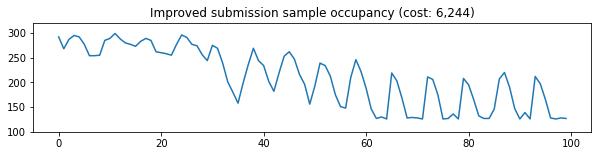

In [210]:
improved_sample_occupancy = calc_daily_occupancy(improved_sample_pred)
distributon_lineplot("Improved submission sample occupancy", improved_sample_occupancy)

In [211]:
improved_sample_pred = iter_improve_prediction(improved_sample_pred)
improved_sample_score = calc_score(improved_sample_pred)
print("Improved submission sample (5 iterations):", locale.format_string("%d", improved_sample_score, grouping=True))

Improved submission sample (5 iterations): 540,353


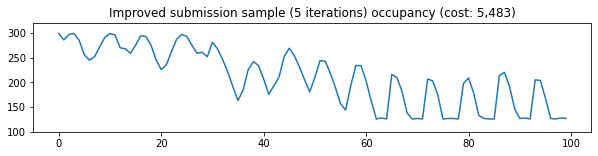

In [212]:
improved_sample_occupancy = calc_daily_occupancy(improved_sample_pred)
distributon_lineplot("Improved submission sample (5 iterations) occupancy", improved_sample_occupancy)

### 3.3 Uniform distribution

In [213]:
# Sort by size to prioritize smaller families (which have a lower preference cost).
sorted_data = data.sort_values(by=['n_people'])

# Initialize variables.
uniform_pred = [-1 for i in range(len(data))]
pred_occupancy = {k:0 for k in DAYS_LIST}
uniform_ideal = sorted_data['n_people'].sum()/N_DAYS
uniform_margin = 2

# Assign families according to their preferences as long they don't exceed the ideal occupancy.
for choice_column in COLUMNS:
    for index, row in sorted_data.iterrows():
        # Check that the family wasn't already assigned.
        if uniform_pred[row.family_id] < 0:
            # Check if there is available on the family's choice.
            family_choice = row[choice_column]
            if (pred_occupancy[family_choice] + row.n_people) <= (uniform_ideal + uniform_margin):
                # Concede choice to family.
                uniform_pred[row.family_id] = family_choice
                pred_occupancy[family_choice] += row.n_people

In [214]:
# Distribute families that couldn't be assigned to any of their choice.
for index, row in sorted_data.iterrows():
    if uniform_pred[row.family_id] < 0:
        # Put the family to the less crowded day.
        min_index = min(pred_occupancy, key=pred_occupancy.get)
        pred_occupancy[min_index] += row.n_people
        uniform_pred[row.family_id] = min_index

uniform_pred_score = calc_score(uniform_pred)
print("Uniform prediction:", locale.format_string("%d", uniform_pred_score, grouping=True))

Uniform prediction: 1,017,933


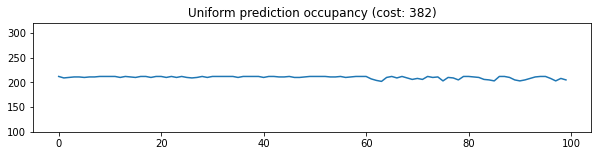

In [215]:
uniform_occupancy = calc_daily_occupancy(uniform_pred)
distributon_lineplot("Uniform prediction occupancy", uniform_occupancy)

In [216]:
improved_uniform_pred = iter_improve_prediction(uniform_pred)
improved_uniform_score = calc_score(improved_uniform_pred)
print("Uniform prediction improved:", locale.format_string("%d", improved_uniform_score, grouping=True))

Uniform prediction improved: 324,636


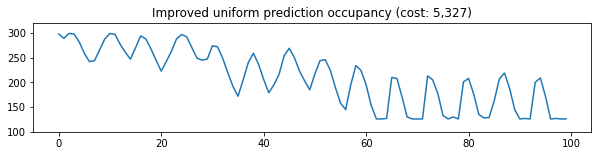

In [217]:
improved_uniform_occupancy = calc_daily_occupancy(improved_uniform_pred)
distributon_lineplot("Improved uniform prediction occupancy", improved_uniform_occupancy)

### 3.4 Decreasing distribution

In [218]:
# Initialize variables.
decreasing_pred = [-1 for i in range(len(data))]
pred_occupancy = {k:0 for k in DAYS_LIST}

step_size = (total_visitors - (MIN_OCCUPANCY*N_DAYS)) / (N_DAYS*(N_DAYS - 1)*0.5) 
decreasing_ideal = {k:(MIN_OCCUPANCY + (N_DAYS-k)*step_size ) for k in DAYS_LIST}
decreasing_margin = 2

# Sort by size to prioritize smaller families (which have a lower preference cost).
sorted_data = data.sort_values(by=['n_people'])

# Assign families according to their preferences as long they don't exceed the ideal occupancy.
for choice_column in COLUMNS:
    for index, row in sorted_data.iterrows():
        # Check that the family wasn't already assigned.
        if decreasing_pred[row.family_id] < 0:
            # Check if there is available on the family's choice.
            family_choice = row[choice_column]
            if (pred_occupancy[family_choice] + row.n_people) <= (decreasing_ideal[family_choice] + decreasing_margin):
                # Concede choice to family.
                decreasing_pred[row.family_id] = family_choice
                pred_occupancy[family_choice] += row.n_people

In [219]:
# Distribute families that couldn't be assigned to any of their choice.
for index, row in sorted_data.iterrows():
    if decreasing_pred[row.family_id] < 0:
        # Put the family to the less crowded day.
        min_index = min(pred_occupancy, key=pred_occupancy.get)
        pred_occupancy[min_index] += row.n_people
        decreasing_pred[row.family_id] = min_index

decreasing_pred_score = calc_score(decreasing_pred)
print("Decreasing prediction:", locale.format_string("%d", decreasing_pred_score, grouping=True))

Decreasing prediction: 693,707


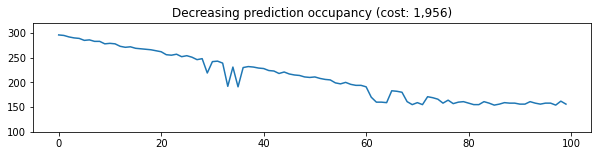

In [220]:
decreasing_occupancy = calc_daily_occupancy(decreasing_pred)
distributon_lineplot("Decreasing prediction occupancy", decreasing_occupancy)

In [221]:
improved_decreasing_pred = iter_improve_prediction(decreasing_pred)
improved_decreasing_score = calc_score(improved_decreasing_pred)
print("Decreasing prediction improved:", locale.format_string("%d", improved_decreasing_score, grouping=True))

Decreasing prediction improved: 345,016


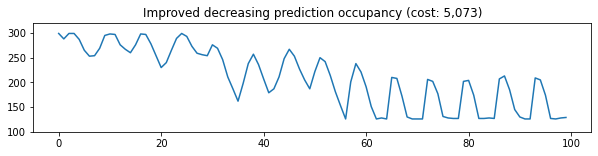

In [222]:
improved_decreasing_occupancy = calc_daily_occupancy(improved_decreasing_pred)
distributon_lineplot("Improved decreasing prediction occupancy", improved_decreasing_occupancy)

### 3.5 Generous distributions

In [223]:
# Initialize variables.
generous_pred = [-1 for i in range(len(data))]
pred_occupancy = {k:0 for k in DAYS_LIST}

# Assign families according to their preferences to meet the minimum occupancy.
for choice_column in COLUMNS:
    for index, row in data.iterrows():
        # Check that the family wasn't already assigned.
        if generous_pred[row.family_id] < 0:
            # Check if there is availability on the family's choice.
            family_choice = row[choice_column]
            if pred_occupancy[family_choice] < MIN_OCCUPANCY:
                # Concede choice to family.
                generous_pred[row.family_id] = family_choice
                pred_occupancy[family_choice] += row.n_people

In [224]:
# Assign families according to their preferences as long they don't exceed the maximum occupancy.
for choice_column in COLUMNS:
    for index, row in sorted_data.iterrows():
        # Check that the family wasn't already assigned.
        if generous_pred[row.family_id] < 0:
            # Check if there is availability on the family's choice.
            family_choice = row[choice_column]
            if (pred_occupancy[family_choice] + row.n_people) <= MAX_OCCUPANCY:
                # Concede choice to family.
                generous_pred[row.family_id] = family_choice
                pred_occupancy[family_choice] += row.n_people

In [225]:
generous_pred_score = calc_score(generous_pred)
print("Generous prediction:", locale.format_string("%d", generous_pred_score, grouping=True))

Generous prediction: 6,198,283,972


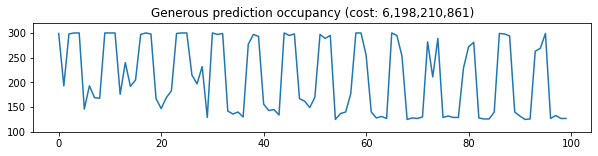

In [226]:
generous_occupancy = calc_daily_occupancy(generous_pred)
distributon_lineplot("Generous prediction occupancy", generous_occupancy)

In [227]:
improved_generous_pred = iter_improve_prediction(generous_pred)
improved_generous_score = calc_score(improved_generous_pred)
print("Generous prediction improved:", locale.format_string("%d", improved_generous_score, grouping=True))

Generous prediction improved: 105,615


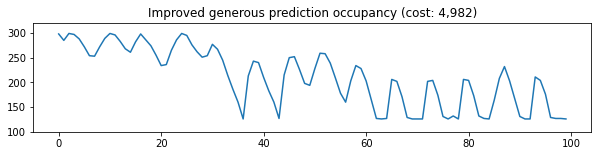

In [228]:
improved_generous_occupancy = calc_daily_occupancy(improved_generous_pred)
distributon_lineplot("Improved generous prediction occupancy", improved_generous_occupancy)

## 4. Make predictions

In [229]:
# Generate the submission file (to be uploaded to Kaggle).
output = pd.DataFrame({'family_id': sample_submission['family_id'], 'assigned_day': improved_generous_pred})
output.to_csv('my_submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
